In [1]:
from Pipeline import BLEPipeline, WifiPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, time
from imblearn.under_sampling import RandomUnderSampler
from itertools import izip, combinations

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create dataset

In [2]:
time_start = time.time()

In [169]:
w = WifiPipeline()

In [4]:
# w.extract_packet_features(create_master=True)

In [5]:
df = w.make_dataframe()

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64


## Resample

In [6]:
# Take out packets from router
df = df[df["DeviceType"]!="router"]

df_train = df[df['Set']=='train']

### Downsampling

In [7]:
# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'SourceAddr', 'Set', 'SubtypeNum'}
onehotEncoded_vars = {'Belkin', 'Data', 'Dropcam', 
                      'Lifi', 'Netgear', 'QoS_Data', 'QoS_Null', 'Tp-link'}
response_vars = {"DeviceType","bulb","camera","router","plug"}

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | set(['Subtype', 'Vendor'])
X = df_train.drop(col_drop, axis=1)

In [8]:
rds = RandomUnderSampler()
X_downsampled, y_downsampled = rds.fit_resample(X, y)

In [9]:
# Recreate dataframe
X_downsampled = pd.DataFrame(data=X_downsampled, columns=X.columns)
y_downsampled = pd.DataFrame(data=y_downsampled, columns=['DeviceType'])

# Onehot encode 'DeviceType'
devicetype_series = pd.get_dummies(y_downsampled['DeviceType'])
y_downsampled = pd.concat([y_downsampled, devicetype_series], axis=1)
y_downsampled = y_downsampled.drop(['DeviceType'],axis=1)

# Combine X and y into one dataframe
df_train_downsampled = pd.concat([X_downsampled, y_downsampled], axis=1)

### Plots

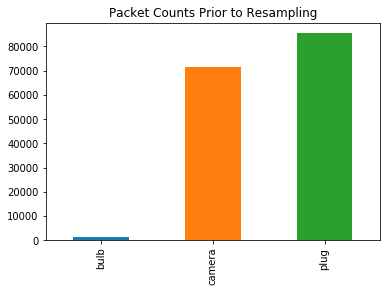

In [10]:
# Resample packets based on DeviceType
# Useful info used from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#
devtype_df = df["DeviceType"].value_counts().sort_index()
devtype_df.plot(kind='bar', title="Packet Counts Prior to Resampling");

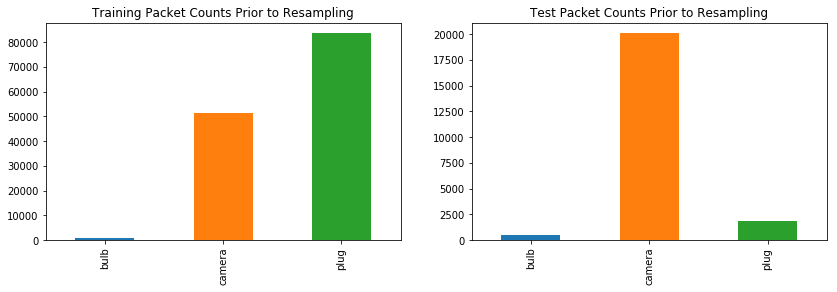

In [11]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling");


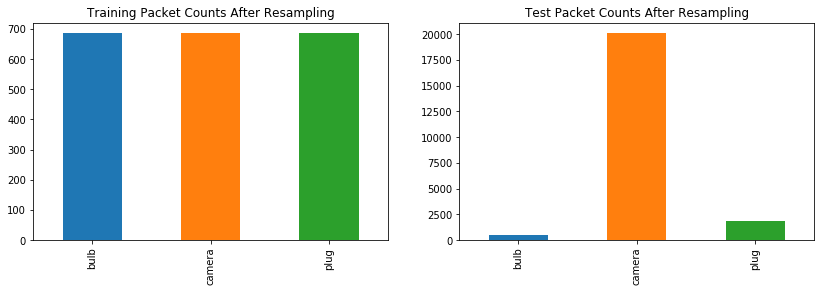

In [12]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[['bulb','camera','plug']].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");


# Run All vs One classification

In [13]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength", 
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["camera", "bulb", "plug"]

In [14]:
# Reinsert Set and DeviceType columns to training dataset
df_train_downsampled['Set'] = 'train'

# Ensure same number of columns in both training and test datasets
train_cols = df_train_downsampled.columns
df_test_samecols = df_test[train_cols]

# Combine training and test sets into one dataframe
df_downsampled = pd.concat([df_train_downsampled,df_test_samecols],axis=0)

In [171]:
one_under_devtype = w.one_vs_one_classify(df_downsampled, features_list, y_list)

Device Pair: ('camera', 'bulb')
--------------------------
--------------------------
RF Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        545       0
camera     5844   14273 

RF Metrics
          FN    FP     TN     TP  Accuracy  Precision    Recall
bulb       0  5844  14273    545  0.717162   0.085303  1.000000
camera  5844     0    545  14273  0.717162   1.000000  0.709499 

--------------------------
KNN Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        537       8
camera       61   20056 

KNN Metrics
        FN  FP     TN     TP  Accuracy  Precision    Recall
bulb     8  61  20056    537  0.996661   0.897993  0.985321
camera  61   8    537  20056  0.996661   0.999601  0.996968 

--------------------------
LDA Confusion Matrix
Predicted  bulb  camera
Actual                 
bulb        545       0
camera     5844   14273 

LDA Metrics
          FN    FP     TN     TP  Accuracy  Precision    Recall
bulb       0  5844  14273    

In [172]:
all_under_devtype = w.one_vs_all_classify(df_downsampled, features_list, y_list)

Device Type: camera
RF

Confusion Matrix
Predicted  camera   rest
Actual                  
camera       2416  17701
rest          102   2313

Metrics
           FN     FP    TN    TP  Accuracy  Precision    Recall
camera  17701    102  2313  2416  0.209879   0.959492  0.120097
rest      102  17701  2416  2313  0.209879   0.115569  0.957764
---------------------------------------------------------
KNN

Confusion Matrix
Predicted  camera   rest
Actual                  
camera       3766  16351
rest           88   2327

Metrics
           FN     FP    TN    TP  Accuracy  Precision    Recall
camera  16351     88  2327  3766  0.270415   0.977167  0.187205
rest       88  16351  3766  2327  0.270415   0.124585  0.963561
---------------------------------------------------------
LDA

Confusion Matrix
Predicted  camera   rest
Actual                  
camera       2961  17156
rest         1504    911

Metrics
           FN     FP    TN    TP  Accuracy  Precision    Recall
camera  17156   1504   9

## Reports

### Confusion Matrix

In [178]:
device_types = ['bulb', 'camera', 'plug']
classifiers = ['KNN', 'LDA', 'RF']

# Extract confusion matrices
device_cms = []
for device in sorted(device_types):
    classifier_cms = {}
    for classifier in sorted(classifiers):
#         classifier_cms.append(all_under_devtype[0][device][classifier]['CM'])
        classifier_cms[classifier] = (all_under_devtype[0][device][classifier]['CM'])
    device_cms.append(classifier_cms)


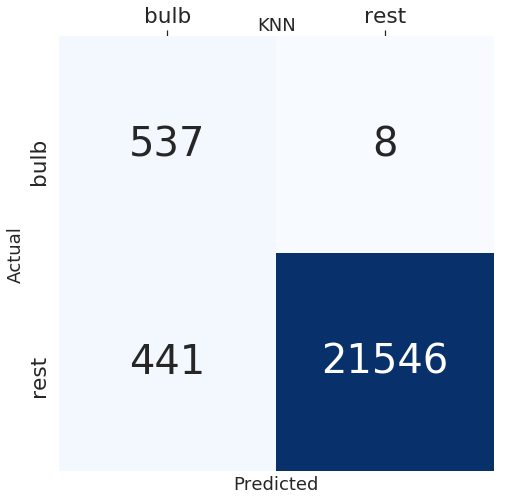

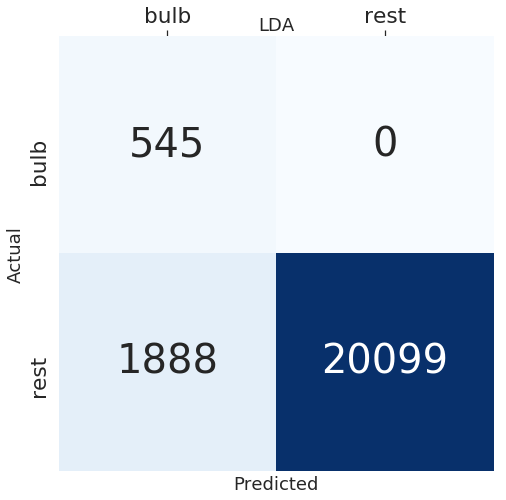

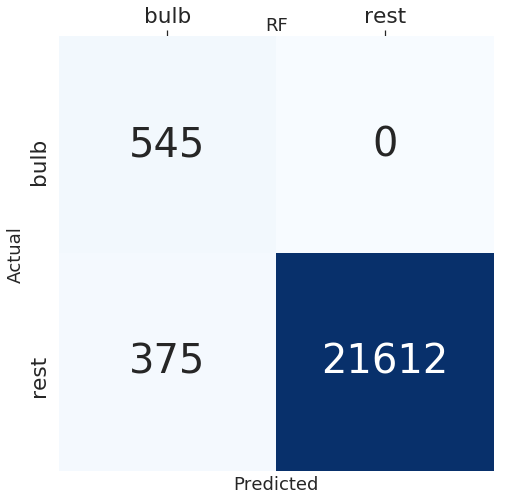

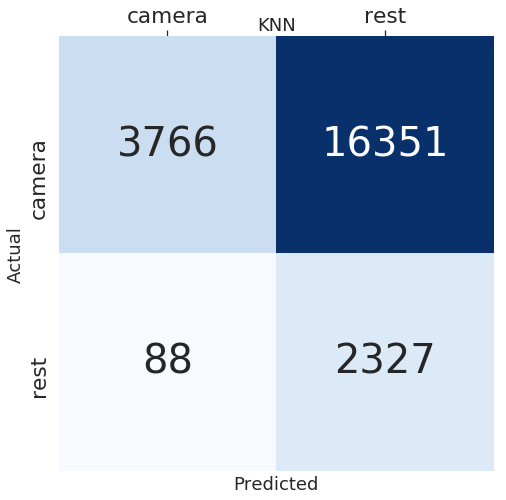

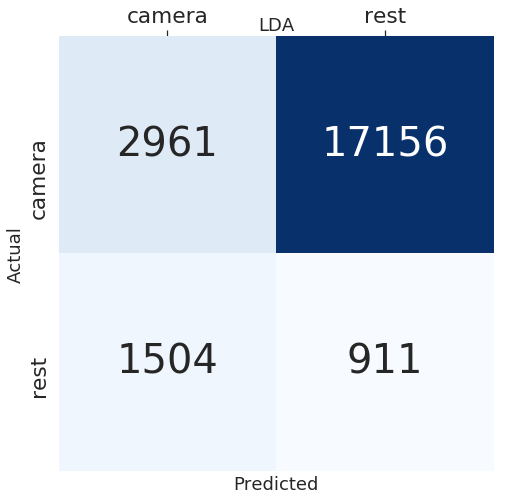

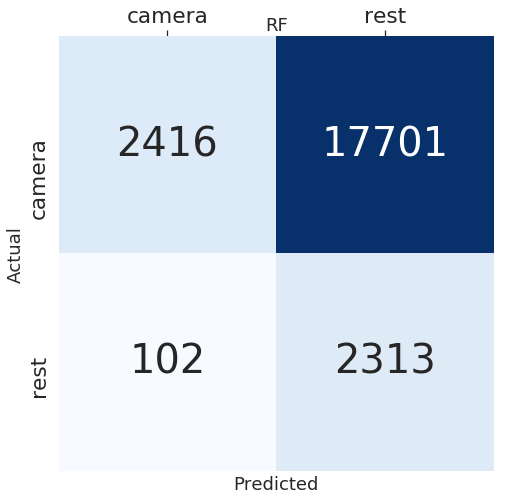

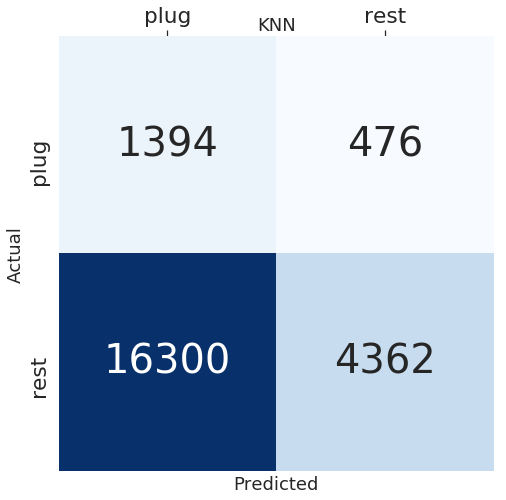

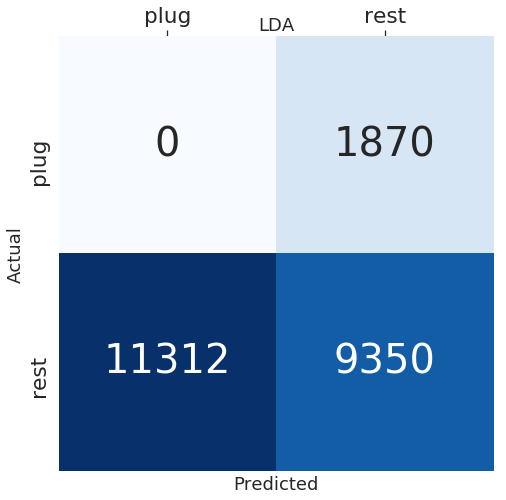

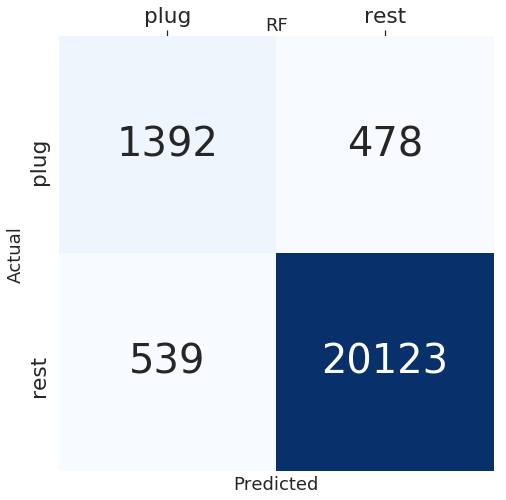

In [182]:
sns.set(font_scale=1.5)
for device_list in device_cms:
    for c,classifier_cm in device_list.iteritems():
        fig, ax = plt.subplots(figsize=(11,8))
        ax.tick_params(labelsize='large')
        ax.xaxis.set_ticks_position('top')
        ax.set_title(c)
        sns.heatmap(classifier_cm, annot=True, annot_kws={"size":40},square=True, fmt='d', cmap='Blues', cbar=False);

### Accuracy, Precision, Recall

In [175]:
# Extract metrics
device_metrics = []
for device in sorted(device_types):
    classifier_metrics = []
    for classifier in sorted(classifiers):
        classifier_metrics.append(all_over_device[0][device][classifier]['Metrics'][['Accuracy','Precision','Recall']].loc[device])
    device_metrics.append(classifier_metrics)


In [176]:
for device_list in device_metrics:
    for classifier_metrics, c in zip(device_list, classifiers):
        print c
        print classifier_metrics, "\n"

KNN
Accuracy     0.980073
Precision    0.549080
Recall       0.985321
Name: bulb, dtype: float64 

LDA
Accuracy     0.916208
Precision    0.224003
Recall       1.000000
Name: bulb, dtype: float64 

RF
Accuracy     0.999112
Precision    0.964602
Recall       1.000000
Name: bulb, dtype: float64 

KNN
Accuracy     0.270415
Precision    0.977167
Recall       0.187205
Name: camera, dtype: float64 

LDA
Accuracy     0.171844
Precision    0.663158
Recall       0.147189
Name: camera, dtype: float64 

RF
Accuracy     0.209746
Precision    0.956539
Recall       0.120346
Name: camera, dtype: float64 

KNN
Accuracy     0.255459
Precision    0.078784
Recall       0.745455
Name: plug, dtype: float64 

LDA
Accuracy     0.414965
Precision    0.000000
Recall       0.000000
Name: plug, dtype: float64 

RF
Accuracy     0.954775
Precision    0.719670
Recall       0.745455
Name: plug, dtype: float64 



### AUC